# Goal

* calculating phylosignal of each OTU abundances
* using residuals from `abundanance ~ diet_components` regression (binomial regression on OTU pres/abs)
* just including Mammalia (since no signficant local signal for non-mammals)

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# otu residuals 
otu_file = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//physeq_IndD-binom_OTU-diet-resid.RDS'

# host cladogram
host_tree_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_20180625_rn_16S-r5k_IndD.nwk'

# params
threads = 12

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)

library(ape)
library(phyloseq)
library(phylosignal)

library(doParallel)
library(future)
library(future.batchtools)
library(future.apply)

source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 
source('/ebio/abt3_projects/Georg_animal_feces/code/itol.R')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel

Attaching package: ‘future.apply’

The following object is masked from ‘package:future’:

    future_lapply



In [3]:
set.seed(7134)

In [4]:
make_dir(work_dir)
setwd(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/ 


## Functions

In [5]:
# phylosignal analysis on each tree subsample
phyloSignal_each = function(i, tree_4d, methods='all', reps=99){
    # phylosignal
    physig_res = phyloSignal(tree_4d[[i]], methods=methods, reps=reps)
    
    # formatting output
    tmp1 = physig_res$stat 
    tmp1$OTU = rownames(tmp1)

    # calculating qvalue on results
    tmp2 = physig_res$pvalue
    tmp3 = apply(tmp2, 2, function(x) p.adjust(x, method='BH')) %>% as.data.frame
    tmp2$OTU = rownames(tmp2)
    tmp3$OTU = rownames(tmp2)

    tmp1 = tmp1 %>%
        gather(method, coef, -OTU)
    tmp2 = tmp2 %>%
        gather(method, pvalue, -OTU)
    tmp3 = tmp3 %>%
        gather(method, qvalue, -OTU)
             
    tmp1 %>%
        inner_join(tmp2, c('OTU', 'method')) %>%
        inner_join(tmp3, c('OTU', 'method')) %>%
        mutate(subsample_rep = i)
}

In [6]:
#' randomly selecting one per group
phylo4d_subsample = function(L, df, otu, tree){
    # get subsample (one sample per species)
    df = df %>% 
        group_by(scientific_name) %>% 
        sample_n(1)
    #df %>% head %>% print
    # getting OTU
    otu = otu[,df$sample] %>% t 
    # subsampling tree
    to_rm = setdiff(tree$tip, rownames(otu))
    tree = drop.tip(tree, to_rm)
    # creating phylo4d 
    tree_4d = phylobase::phylo4d(tree, tip.data=otu)
    return(tree_4d)
}

In [7]:
#' lipamoran analysis on each trait
lipamoran_each = function(i, tree_4d, traits, reps=99){
    # phylosignal
    doParallel::registerDoParallel(threads)
    lipa_res = plyr::llply(as.list(traits), lipaMoran_per_OTU, tree_4d=tree_4d[[i]], reps=reps, .parallel=TRUE)
    # formatting
    lipa_res = do.call(rbind, lipa_res)
    lipa_res$subsample_rep = i
    return(lipa_res)
}

# Load

In [10]:
# metadata
metadata = readRDS(physeq_file) %>%
    subset_samples(class == 'Mammalia') %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame

metadata$Sample_ID = rownames(metadata)
metadata %>% dfhead

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘

[1] 160 172


,X.SampleID,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,⋯,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description,Sample_ID
X1.Eurasian.Beaver,X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,Biber,Eurasian.Beaver,⋯,4,120,18,18,NA,1,20,1,NA,X1.Eurasian.Beaver
X101.Horse,X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,101,Hauspferd,Horse,⋯,16,344,160,160,NA,2,20,101,NA,X101.Horse
X102.Kulan,X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,102,Khulan,Kulan,⋯,16,345,161,161,NA,2,20,102,NA,X102.Kulan


In [15]:
# OTU table
otu = readRDS(otu_file) 
otu = otu[,rownames(metadata)]
otu %>% dim

[1] 408 160

In [16]:
# taxonomy
tax = readRDS(physeq_file) %>%
    tax_table %>%
    as.matrix %>% 
    as.data.frame

tax$OTU = gsub('^([0-9])', 'X\\1', rownames(tax))
rownames(tax) = 1:nrow(tax)

tax %>% dfhead

[1] 30290     8


Domain,Phylum,Class,Order,Family,Genus,Species,OTU
Bacteria,Candidate division SR1,unclassified,unclassified,unclassified,unclassified,unclassified,ea2df9bcd7f6a10e0fa509d237d19c6d
Bacteria,Candidate division SR1,uncultured bacterium,,,,,X130b094f31455943fb20899a36af8afd
Bacteria,Candidate division SR1,uncultured bacterium,,,,,b9b9562a0f34ad60c552f7f46d7a4b3b


In [17]:
# adding higher level taxonomy if 'uncultured' 
to_rm = c('', 'uncultured', 'unclassified', 'Incertae Sedis', 'uncultured archaeon', 
          'uncultured bacterium', 'uncultured rumen bacterium')

tax = tax %>%
    mutate(Phylum = Phylum %>% as.character,
           Class = Class %>% as.character,
           Order = Order %>% as.character,
           Family = Family %>% as.character,
           Genus = Genus %>% as.character,
           Species = Species %>% as.character) %>%
    mutate(Class = ifelse(Class %in% to_rm, Phylum, Class),
           Order = ifelse(Order %in% to_rm, Class, Order),
           Family = ifelse(Family %in% to_rm, Order, Family),
           Genus = ifelse(Genus %in% to_rm, Family, Genus),
           Species = ifelse(Species %in% to_rm, Genus, Species)) 

tax %>% dfhead

[1] 30290     8


Domain,Phylum,Class,Order,Family,Genus,Species,OTU
Bacteria,Candidate division SR1,Candidate division SR1,Candidate division SR1,Candidate division SR1,Candidate division SR1,Candidate division SR1,ea2df9bcd7f6a10e0fa509d237d19c6d
Bacteria,Candidate division SR1,Candidate division SR1,Candidate division SR1,Candidate division SR1,Candidate division SR1,Candidate division SR1,X130b094f31455943fb20899a36af8afd
Bacteria,Candidate division SR1,Candidate division SR1,Candidate division SR1,Candidate division SR1,Candidate division SR1,Candidate division SR1,b9b9562a0f34ad60c552f7f46d7a4b3b


In [18]:
# checking OTU ID overlap
setdiff(rownames(otu), readRDS(physeq_file) %>% otu_table %>% rownames) %>% length %>% print

[1] 0


In [21]:
# host tree
host_tree = read.tree(host_tree_file)
host_tree$tip.label = gsub('^([0-9])', 'X\\1', host_tree$tip.label)

to_rm = setdiff(host_tree$tip.label, colnames(otu))
host_tree = ape::drop.tip(host_tree, to_rm)
host_tree


Phylogenetic tree with 160 tips and 124 internal nodes.

Tip labels:
	X362.Gray.Four.eyed.Opossum, X283.Koala, X369.Koala, X289.Eastern.Grey.Kangaroo, X290.Eastern.Grey.Kangaroo, X279.Western.Grey.Kangaroo, ...
Node labels:
	Node54, Node55, Node56, Node57, Node58, Node59, ...

Rooted; includes branch lengths.

# Phylosignal

In [22]:
# convert to phylo4d
host_tree_4d = phylobase::phylo4d(host_tree, tip.data=t(otu))
host_tree_4d %>% summary

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’


 Length   Class    Mode 
      1 phylo4d      S4 

In [23]:
# phylosignal calculation
#-- WARNING: slow --#
physig_res = phyloSignal(host_tree_4d, methods = 'all', reps = 999)

## Saving results

In [24]:
# results obj. file 
out_file = file.path(work_dir, 'OTU-binom_physig_IndD-sens_justMam.RDS')
out_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//OTU-binom_physig_IndD-sens_justMam.RDS"

In [25]:
# saving
saveRDS(physig_res, file=out_file)
cat('File written:', out_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//OTU-binom_physig_IndD-sens_justMam.RDS 


In [26]:
# reloading obj.
physig_res = readRDS(out_file)
physig_res %>% length

[1] 2

In [27]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/phylosignal/host_TT/3b_OTU-binom_phylosignal_IndD_diet-resid_justMam.ipynb')

## Formatting

In [28]:
# formatting output
tmp1 = physig_res$stat 
tmp1$OTU = rownames(tmp1)

tmp2 = physig_res$pvalue
tmp3 = apply(tmp2, 2, function(x) p.adjust(x, method='BH')) %>% as.data.frame
tmp2$OTU = rownames(tmp2)
tmp3$OTU = rownames(tmp2)

tmp1 = tmp1 %>%
    gather(method, coef, -OTU)
tmp2 = tmp2 %>%
    gather(method, pvalue, -OTU)
tmp3 = tmp3 %>%
    gather(method, qvalue, -OTU)
             
physeq_res_j = tmp1 %>%
    inner_join(tmp2, c('OTU', 'method')) %>%
    inner_join(tmp3, c('OTU', 'method'))
             
tmp1 %>% nrow %>% print
physeq_res_j %>% dfhead

[1] 2040
[1] 2040    5


OTU,method,coef,pvalue,qvalue
X368bd5c2255f3a5ce0fef06ca6de1d04,Cmean,0.2569270,0.001,0.001505535
X779324e5648460c5a67e577c45131b42,Cmean,0.3627958,0.001,0.001505535
b918d185ee89a0b33d821ee766d76eb3,Cmean,0.2454572,0.001,0.001505535


File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/IndD-OTU-binom_physignal-global_justMam.pdf 


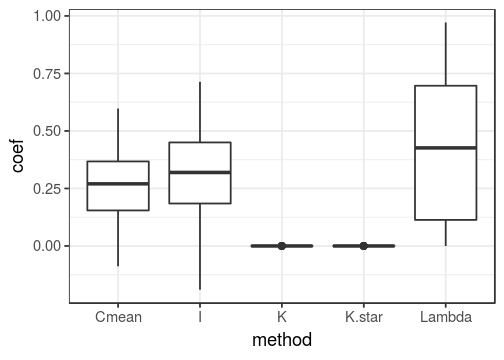

In [29]:
# plotting coef distribution
p = ggplot(physeq_res_j, aes(method, coef)) +
    geom_boxplot() +
    theme_bw()

options(repr.plot.width=4.2, repr.plot.height=3)
plot_write(p, file='IndD-OTU-binom_physignal-global_justMam.pdf')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/fig-d4a8cf3fecddf099ff7f45bc.pdf 


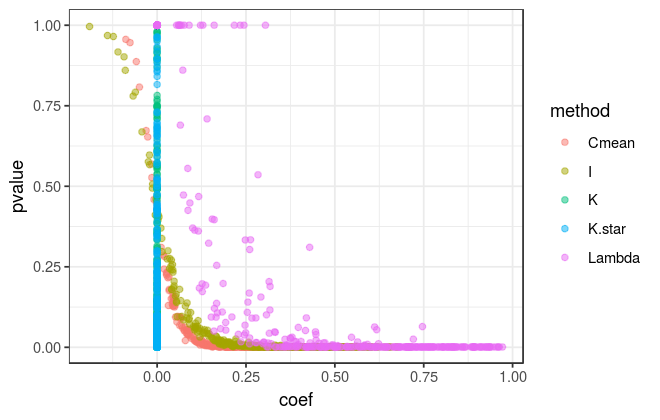

In [30]:
# plotting pvalue distribution
p = ggplot(physeq_res_j, aes(coef, pvalue, color=method)) +
    geom_point(alpha=0.5) +
    theme_bw()

options(repr.plot.width=5.5, repr.plot.height=3.5)
plot_write(p)

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/IndD-OTU-binom_physignal-global-qvalue_justMam.pdf 


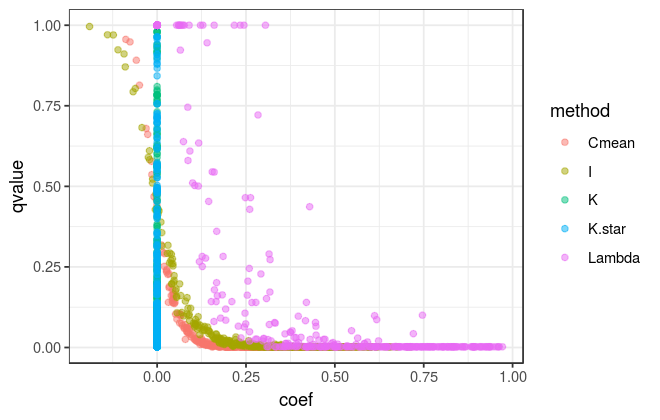

In [31]:
# plotting qvalue distribution
p = ggplot(physeq_res_j, aes(coef, qvalue, color=method)) +
    geom_point(alpha=0.5) +
    theme_bw()

options(repr.plot.width=5.5, repr.plot.height=3.5)
plot_write(p, file='IndD-OTU-binom_physignal-global-qvalue_justMam.pdf')

## Adding taxonomy

In [32]:
physeq_res_j %>% nrow %>% print
physeq_res_j = physeq_res_j %>%
    inner_join(tax, c('OTU')) 

physeq_res_j %>% dfhead

[1] 2040
[1] 2040   12


OTU,method,coef,pvalue,qvalue,Domain,Phylum,Class,Order,Family,Genus,Species
X368bd5c2255f3a5ce0fef06ca6de1d04,Cmean,0.2569270,0.001,0.001505535,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
X779324e5648460c5a67e577c45131b42,Cmean,0.3627958,0.001,0.001505535,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
b918d185ee89a0b33d821ee766d76eb3,Cmean,0.2454572,0.001,0.001505535,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter


## Significant OTUs

### All metrics

In [33]:
physeq_res_j_f = physeq_res_j %>%
    filter(qvalue < 0.05) %>%
    group_by(OTU) %>%
    mutate(n_methods = method %>% unique %>% length) %>%
    ungroup() %>%
    mutate(Genus = Genus %>% as.character,
           Genus = Genus %>% reorder(Phylum %>% as.factor %>% as.numeric))

physeq_res_j_f$OTU %>% unique %>% length %>% print
physeq_res_j_f %>% dfhead

[1] 364
[1] 1371   13


OTU,method,coef,pvalue,qvalue,Domain,Phylum,Class,Order,Family,Genus,Species,n_methods
X368bd5c2255f3a5ce0fef06ca6de1d04,Cmean,0.2569270,0.001,0.001505535,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,5
X779324e5648460c5a67e577c45131b42,Cmean,0.3627958,0.001,0.001505535,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,5
b918d185ee89a0b33d821ee766d76eb3,Cmean,0.2454572,0.001,0.001505535,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,3


File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/phylosig_OTU-binom_sig-OTUs_diet-resid_justMam.pdf 


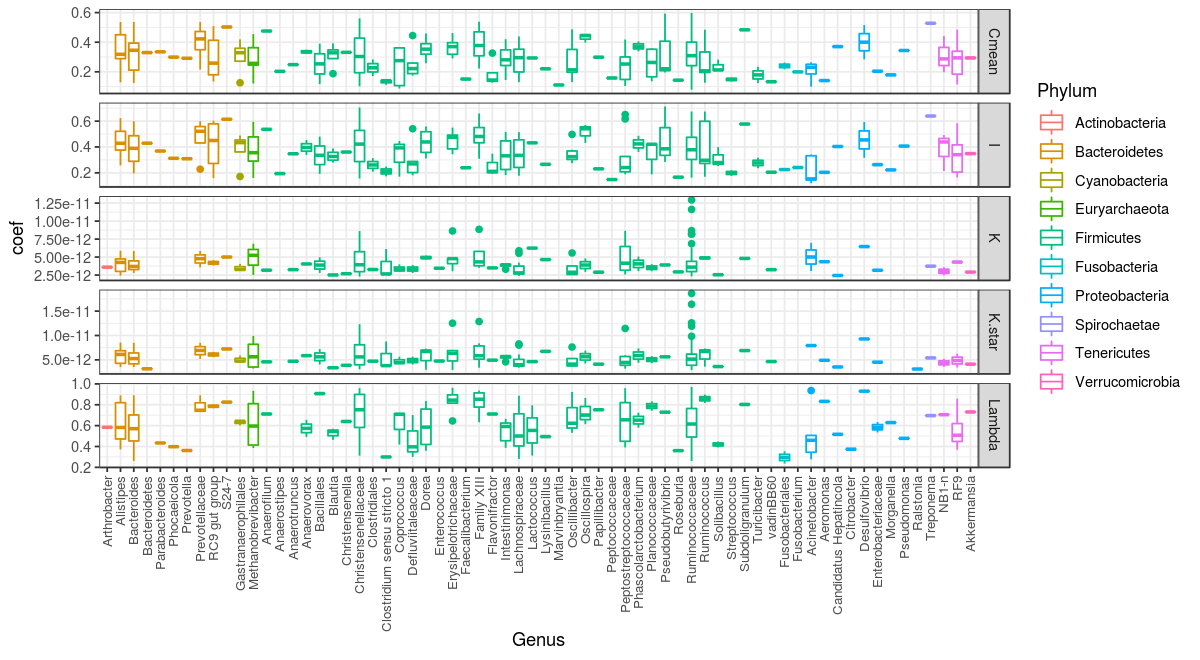

In [34]:
# plotting coef. values for each taxonomic group
p = ggplot(physeq_res_j_f, aes(Genus, coef, color=Phylum)) +
    geom_boxplot() +
    facet_grid(method ~ ., scales='free_y') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, size=8)
    )
        
options(repr.plot.width=10, repr.plot.height=5.5)
plot_write(p, file='phylosig_OTU-binom_sig-OTUs_diet-resid_justMam.pdf')

### Just Moran's I

In [35]:
# formatting
physeq_res_j_f = physeq_res_j %>%
    filter(qvalue < 0.05,
           method == 'I') %>%
    group_by(OTU) %>%
    mutate(n_methods = method %>% unique %>% length) %>%
    ungroup() %>%
    unite(Taxonomy, Phylum, Class, Order, Family, Genus, sep='; ', remove=FALSE) %>%
    mutate(Taxonomy = Taxonomy %>% as.character,
           #Taxonomy = stringr::str_wrap(Taxonomy, 60),
           Taxonomy = Taxonomy %>% reorder(coef))

physeq_res_j_f$OTU %>% unique %>% length %>% print
physeq_res_j_f %>% dfhead

[1] 332
[1] 332  14


OTU,method,coef,pvalue,qvalue,Domain,Taxonomy,Phylum,Class,Order,Family,Genus,Species,n_methods
X368bd5c2255f3a5ce0fef06ca6de1d04,I,0.3557310,0.001,0.001924528,Archaea,Euryarchaeota; Methanobacteria; Methanobacteriales; Methanobacteriaceae; Methanobrevibacter,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,1
X779324e5648460c5a67e577c45131b42,I,0.4779851,0.001,0.001924528,Archaea,Euryarchaeota; Methanobacteria; Methanobacteriales; Methanobacteriaceae; Methanobrevibacter,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,1
b918d185ee89a0b33d821ee766d76eb3,I,0.2907885,0.006,0.009066667,Archaea,Euryarchaeota; Methanobacteria; Methanobacteriales; Methanobacteriaceae; Methanobrevibacter,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,1


File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/phylosig_OTU-binom_sig-OTUs_diet-resid_moranI_justMam.pdf 


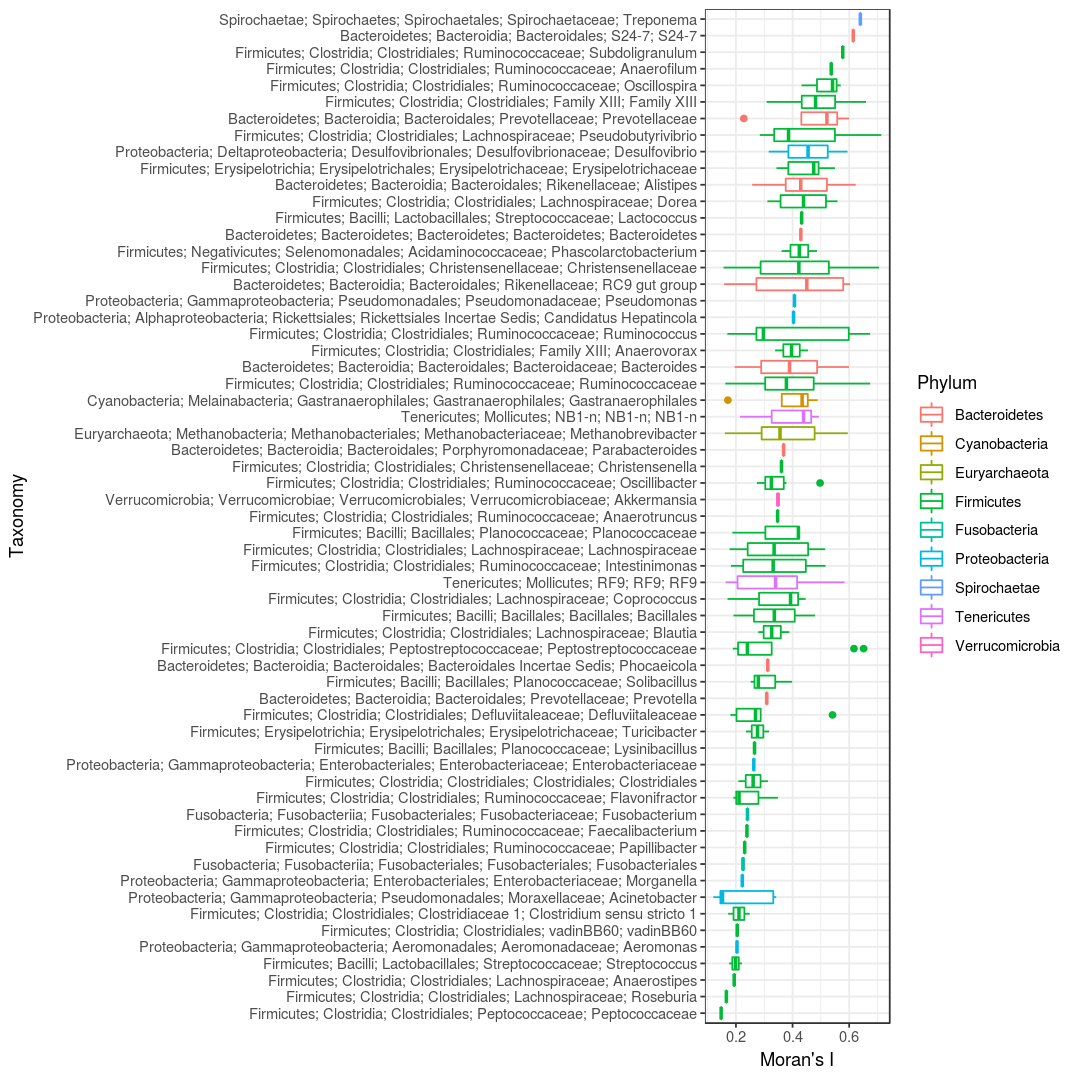

In [36]:
# plotting coef. values for each taxonomic group
p = ggplot(physeq_res_j_f, aes(Taxonomy, coef, color=Phylum)) +
    geom_boxplot() +
    labs(y='Moran\'s I') +
    coord_flip() +
    theme_bw()
        
options(repr.plot.width=9, repr.plot.height=9)
plot_write(p, file='phylosig_OTU-binom_sig-OTUs_diet-resid_moranI_justMam.pdf')

# Phylosignal sensitivity analysis

* subsampling 1 sample per species

## Subsampling host tree

In [37]:
# subsampling tree
df = metadata %>%
    mutate(sample = rownames(.)) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_4d = plyr::llply(as.list(1:100), 
                  function(x) phylo4d_subsample(x, df, otu, host_tree),
                  .parallel=TRUE)
host_tree_4d %>% length

[1] 100

## Phylosig

In [38]:
# cluster resources
resources = list(h_rt = '24:00:00',
                 h_vmem = '10G',
                 threads = '1',
                 conda.env = 'py3_physeq_phylo', 
                 conda.path = "/ebio/abt3_projects/software/miniconda3_gt4.4/bin")
plan(batchtools_sge, resources=resources)

In [39]:
# phylosignal calculation
# WARNING: slow
methods = c("I")   # just moran's I
x = as.list(1:length(host_tree_4d))
#physeq_sub_res = plyr::llply(as.list(1:3), 
physeq_sub_res = future_lapply(x,
                               phyloSignal_each,
                               tree_4d=host_tree_4d,
                               methods=methods, 
                               reps=999,
                               future.packages=c('phylosignal'))

physeq_sub_res %>% length

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vec

[1] 100

In [40]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/phylosignal/host_TT/3b_OTU-binom_phylosignal_IndD_diet-resid_justMam.ipynb')

### Saving resuls

In [41]:
# results object file
out_file = file.path(work_dir, 'phylosignal_OTU-binom_IndD_sens_justMam.RDS')
out_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//phylosignal_OTU-binom_IndD_sens_justMam.RDS"

In [42]:
# saving results
saveRDS(physeq_sub_res, file=out_file)
cat('File written:', out_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//phylosignal_OTU-binom_IndD_sens_justMam.RDS 


In [43]:
# re-loading results
physeq_sub_res = readRDS(out_file)
physeq_sub_res %>% class %>% print
physeq_sub_res %>% length %>% print

[1] "list"
[1] 100


## Formatting

In [44]:
# combining results
physeq_sub_res = do.call(rbind, physeq_sub_res)
physeq_sub_res %>% dim

[1] 40800     6

## Adding taxonomy

In [45]:
# join with tax table
physeq_sub_res %>% nrow %>% print

physeq_sub_res = physeq_sub_res %>%
    inner_join(tax, c('OTU')) 

physeq_sub_res %>% dfhead

[1] 40800
[1] 40800    13


OTU,method,coef,pvalue,qvalue,subsample_rep,Domain,Phylum,Class,Order,Family,Genus,Species
X368bd5c2255f3a5ce0fef06ca6de1d04,I,0.067990362,0.005,0.04533333,1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
X779324e5648460c5a67e577c45131b42,I,0.050193971,0.020,0.08589474,1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
b918d185ee89a0b33d821ee766d76eb3,I,-0.003481808,0.271,0.55561809,1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter


## Significant OTUs

In [46]:
## all OTUs with sig p-value in >= 95% of reps
physeq_sub_res_s = physeq_sub_res %>%
    group_by(OTU, method, Domain, Phylum, Class, Order, Family, Genus) %>%
    summarize(median_coef = median(coef),
              mean_coef = mean(coef),
              sd_coef = sd(coef),
              qvalue = (length(qvalue) - sum(qvalue < 0.05)) / length(qvalue)) %>%
    ungroup() %>%
    unite(Taxonomy, Phylum, Class, Order, Family, sep='; ', remove=FALSE)

physeq_sub_res_s %>% dfhead

[1] 408  13


OTU,method,Domain,Taxonomy,Phylum,Class,Order,Family,Genus,median_coef,mean_coef,sd_coef,qvalue
a00218cf61edc4c39ad85d492251426f,I,Bacteria,Firmicutes; Clostridia; Clostridiales; Ruminococcaceae,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,-0.01981725,-0.01541971,0.01660295,1
a01db188e170d6297f7e939e7c73be61,I,Bacteria,Firmicutes; Clostridia; Clostridiales; Peptostreptococcaceae,Firmicutes,Clostridia,Clostridiales,Peptostreptococcaceae,Peptostreptococcaceae,0.03155758,0.03261279,0.00580421,1
a36392611a398d344696b8ab75fe4d08,I,Bacteria,Bacteroidetes; Bacteroidia; Bacteroidales; Rikenellaceae,Bacteroidetes,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,-0.01045168,-0.01019161,0.01727227,1


In [47]:
# check: one value per OTU + method?
physeq_sub_res_s %>%
    group_by(OTU, method) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    .$n %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

In [48]:
# number of significant OTUs
n_sig_OTUs = physeq_sub_res_s %>%
    filter(qvalue < 0.05) %>%
    distinct(OTU) %>%
    nrow

cat('Number of globally sig. OTUs:', n_sig_OTUs, '\n')

Number of globally sig. OTUs: 0 


In [49]:
# formatting
physeq_sub_res_s_f = physeq_sub_res_s %>%
    filter(qvalue < 0.05,
           method == 'I') %>%
    group_by(Phylum, Class, Order, Family) %>%
    mutate(n_OTUs = OTU %>% unique %>% length) %>%
    ungroup() %>%
    mutate(Taxonomy = Taxonomy %>% as.character,
           Taxonomy = Taxonomy %>% reorder(mean_coef)) 

physeq_sub_res_s_f$OTU %>% unique %>% length %>% print
physeq_sub_res_s_f %>% dfhead

[1] 0
[1]  0 14


OTU,method,Domain,Taxonomy,Phylum,Class,Order,Family,Genus,median_coef,mean_coef,sd_coef,qvalue,n_OTUs


File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/phylosignal_OTU-binom_IndD_sens_nOTUs_justMam.pdf 


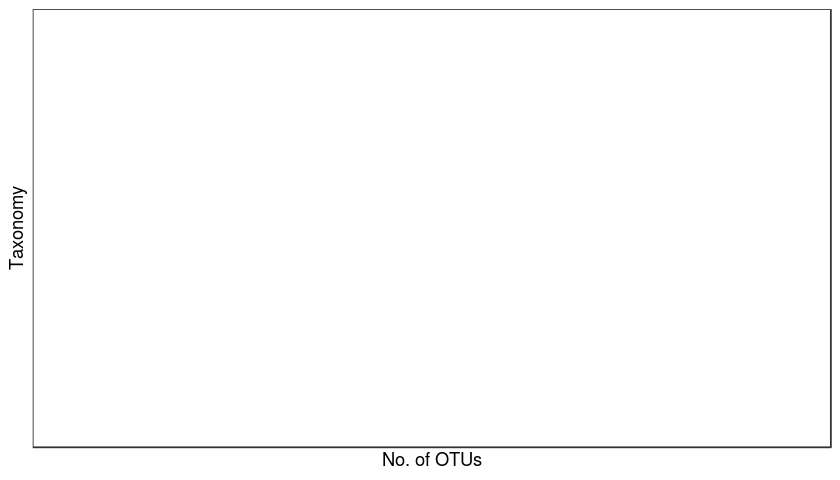

In [50]:
# summary
p = physeq_sub_res_s_f %>% 
    ggplot(aes(Taxonomy, fill=Phylum)) +
    geom_bar() +
    labs(y='No. of OTUs') +
    coord_flip() +
    theme_bw() 

options(repr.plot.width=7, repr.plot.height=4)
plot_write(p, file='phylosignal_OTU-binom_IndD_sens_nOTUs_justMam.pdf')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/phylosignal_OTU-binom_IndD_sens_box_justMam.pdf 


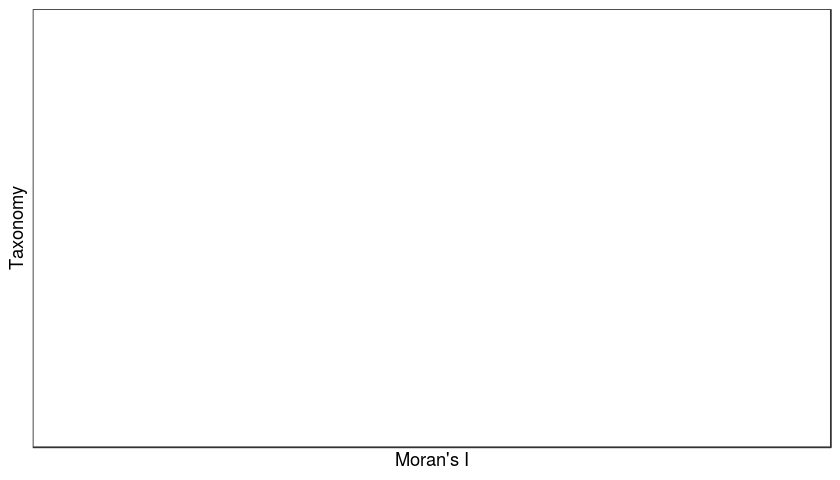

In [51]:
# plotting coef. values for each taxonomic group
p = ggplot(physeq_sub_res_s_f, aes(Taxonomy, mean_coef, color=Phylum)) +
    geom_boxplot() +
    geom_jitter(width=0.25, height=0, shape='O', color='black') +
    labs(y='Moran\'s I') +
    coord_flip() +
    theme_bw()
        
options(repr.plot.width=7, repr.plot.height=4)
plot_write(p, file='phylosignal_OTU-binom_IndD_sens_box_justMam.pdf')

# Location on host tree

Measuring local phylogenetic signal

In [52]:
# convert to phylo4d
host_tree_4d = phylobase::phylo4d(host_tree, tip.data=t(otu))
host_tree_4d %>% summary

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’


 Length   Class    Mode 
      1 phylo4d      S4 

## `lipaMoran`

In [53]:
lipaMoran_per_OTU = function(trait, tree_4d, reps=9999){
    res = lipaMoran(tree_4d, trait=trait, reps=reps, prox.phylo = "nNodes")
    z = colnames(res$lipa)[1]
    x = res$lipa
    colnames(x) = c('coef')
    y = res$p.value 
    colnames(y) = c('pvalue')
    df = cbind(x,y) %>% as.data.frame
    df$OTU = z
    df$host = rownames(df)
    rownames(df) = 1:nrow(df)
    return(df)
}

traits = physeq_res_j_f$OTU %>% unique
traits %>% length

[1] 332

In [54]:
# running in parallel
registerDoParallel(cores=threads)
lipa_res = plyr::llply(as.list(traits), 
                       lipaMoran_per_OTU, 
                       tree_4d=host_tree_4d,
                       reps=999,
                       .parallel=TRUE)
lipa_res = do.call(rbind, lipa_res)
lipa_res %>% dfhead

[1] 53120     4


coef,pvalue,OTU,host
0.0009468388,0.432,X368bd5c2255f3a5ce0fef06ca6de1d04,X362.Gray.Four.eyed.Opossum
0.0138606593,0.280,X368bd5c2255f3a5ce0fef06ca6de1d04,X283.Koala
0.0149459380,0.277,X368bd5c2255f3a5ce0fef06ca6de1d04,X369.Koala


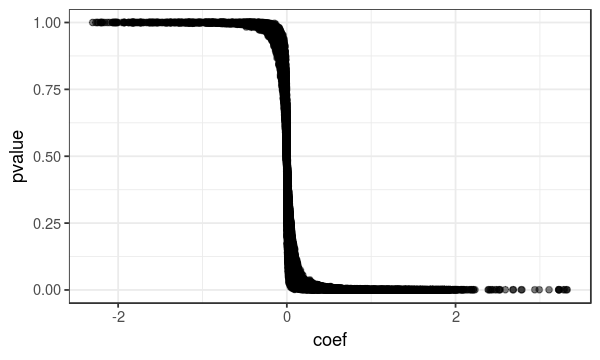

In [55]:
# plotting pvalue ~ coef
p = ggplot(lipa_res, aes(coef, pvalue)) +
    geom_point(alpha=0.5) +
    theme_bw() 

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [56]:
# adjusting p-values
lipa_res$qvalue = p.adjust(lipa_res$pvalue, method='BH')
lipa_res$qvalue %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02754 0.27521 0.54685 0.51195 0.69184 1.00000 

In [57]:
# significant OTUs
lipa_res_f = lipa_res %>%
    filter(qvalue < 0.05) %>%
    inner_join(tax, c('OTU'))

lipa_res_f %>% dfhead

[1] 2335   12


coef,pvalue,OTU,host,qvalue,Domain,Phylum,Class,Order,Family,Genus,Species
0.5814073,0.001,X368bd5c2255f3a5ce0fef06ca6de1d04,X137.Gaur,0.02753758,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
0.5588235,0.001,X368bd5c2255f3a5ce0fef06ca6de1d04,X138.Gaur,0.02753758,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
0.5736154,0.002,X368bd5c2255f3a5ce0fef06ca6de1d04,X420.Cattle,0.04549893,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter


In [58]:
# number of significant OTUs
lipa_res_f$OTU %>% unique %>% length

[1] 325

### Formatting for iTOL


Setting initial dates...
Fitting in progress... get a first set of estimates
         Penalised log-lik = -703.3678 
Optimising rates... dates... -703.3678 
Optimising rates... dates... -703.3678 

Done.


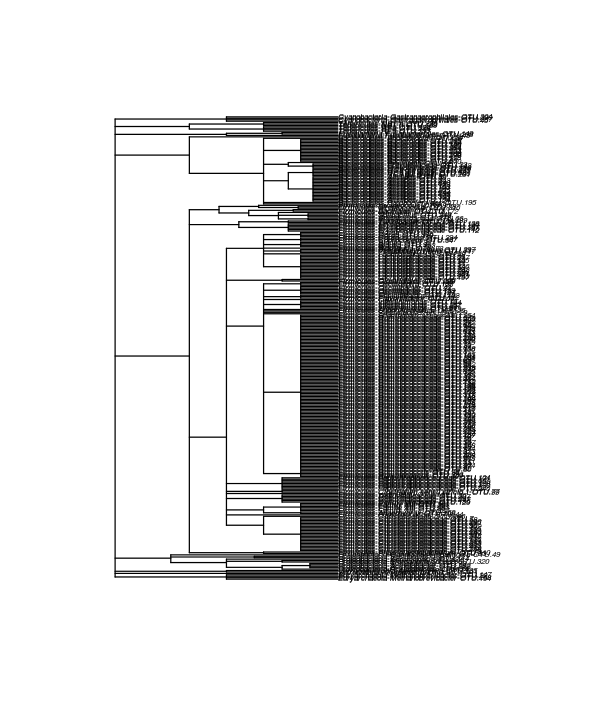

In [59]:
# creating cladogram of taxa
to_rm = c('unclassified', 'uncultured')
tmp = lipa_res_f %>%
    distinct(Domain, Phylum, Class, Order, Family, Genus, OTU) %>%
    mutate(OTU_ID = gsub('^', 'OTU.', OTU %>% as.factor %>% as.numeric)) %>%
    mutate(Family = Family %>% as.character,
           Genus = Genus %>% as.character,
           Genus = ifelse(Genus %in% to_rm, Family, Genus)) %>%
    unite('Genus_OTU', c('Phylum', 'Genus', 'OTU_ID'), sep='-', remove=FALSE) %>%
    mutate(Domain = Domain %>% as.factor,
           Phylum = Phylum %>% as.factor,
           Class = Class %>% as.factor,
           Order = Order %>% as.factor,
           Family = Family %>% as.factor,
           Genus = Genus %>% as.factor,
           Genus_OTU = Genus_OTU %>% as.factor) 

clado = as.phylo(~Phylum/Class/Order/Family/Genus/Genus_OTU, data=tmp)
clado = compute.brlen(clado, 1)
clado = chronos(clado)
options(repr.plot.height=6)
plot(clado, cex=0.4)

In [60]:
lipa_res_f_s = lipa_res_f %>% 
    inner_join(tmp %>% dplyr::select(OTU, Genus_OTU), c('OTU')) %>%
    dplyr::select(Genus_OTU, host, coef) %>%
    spread(Genus_OTU, coef) %>%
    right_join(data.frame(tips = host_tree$tip.label), 
               c('host'='tips')) 

rownames(lipa_res_f_s) = gsub('X([0-9])', '\\1', lipa_res_f_s$host)
lipa_res_f_s$host = NULL
lipa_res_f_s %>% dfhead

Warning message:
“Column `host`/`tips` joining character vector and factor, coercing into character vector”

[1] 160 325


,Bacteroidetes-Alistipes-OTU.103,Bacteroidetes-Alistipes-OTU.123,Bacteroidetes-Alistipes-OTU.124,Bacteroidetes-Alistipes-OTU.133,Bacteroidetes-Alistipes-OTU.153,Bacteroidetes-Alistipes-OTU.154,Bacteroidetes-Alistipes-OTU.155,Bacteroidetes-Alistipes-OTU.230,Bacteroidetes-Alistipes-OTU.240,Bacteroidetes-Alistipes-OTU.243,⋯,Spirochaetae-Treponema-OTU.91,Tenericutes-NB1-n-OTU.132,Tenericutes-NB1-n-OTU.276,Tenericutes-NB1-n-OTU.289,Tenericutes-RF9-OTU.193,Tenericutes-RF9-OTU.218,Tenericutes-RF9-OTU.237,Tenericutes-RF9-OTU.324,Verrucomicrobia-Akkermansia-OTU.135,Verrucomicrobia-Akkermansia-OTU.261
362.Gray.Four.eyed.Opossum,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
283.Koala,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
369.Koala,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [61]:
itol_htmp_file = file.path(work_dir, 'OTU-binom_IndD_lipaMoran_sig_htmp_justMam.txt')
labs = gsub(' ', '_', colnames(lipa_res_f_s))
labs = sprintf('FIELD_LABELS %s\n', paste(labs, collapse=' '))

cat('DATASET_HEATMAP\n', file=itol_htmp_file)
cat('SEPARATOR SPACE\n', file=itol_htmp_file, append=TRUE)
cat('DATASET_LABEL local_Morans_I\n', file=itol_htmp_file, append=TRUE)
cat('COLOR #ff0000\n', file=itol_htmp_file, append=TRUE)
cat(labs, file=itol_htmp_file, append=TRUE)

cat('FIELD_TREE ', file=itol_htmp_file, append=TRUE)
write.tree(clado, file=itol_htmp_file, append=TRUE)
cat('DATA\n', file=itol_htmp_file, append=TRUE)
write.table(lipa_res_f_s, file=itol_htmp_file, append=TRUE, sep=' ', 
            quote=FALSE, col.names=FALSE)

cat('File written:', itol_htmp_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//OTU-binom_IndD_lipaMoran_sig_htmp_justMam.txt 


## `lipaMoran` sensitivity analysis

### Subsampling host tree

In [62]:
# subsampling host trees (1 sample per species)
df = metadata %>%
    mutate(sample = X.SampleID) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_4d = plyr::llply(as.list(1:100), 
                  function(x) phylo4d_subsample(x, df, otu, host_tree),
                  .parallel=TRUE)
host_tree_4d %>% length

[1] 100

### LIPA run

In [63]:
# cluster resources
resources = list(h_rt = '24:00:00',
                 h_vmem = '10G',
                 threads = '1',
                 conda.env = 'py3_physeq_phylo', 
                 conda.path = "/ebio/abt3_projects/software/miniconda3_gt4.4/bin")
plan(batchtools_sge, resources=resources)

In [ ]:
# phylosignal calculation
## WARNING: SLOW
lipa_sub_res = future_lapply(as.list(1:length(host_tree_4d)), 
                             lipamoran_each,
                             tree_4d=host_tree_4d, 
                             traits=traits, 
                             reps=9999,
                             future.packages=c('phylosignal'))


Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vec

In [99]:
lipa_sub_res %>% length

[1] 5

### Saving results

In [96]:
# file
out_file = file.path(work_dir, 'OTU-binom_lipaMoran_IndD_sens_justMam.RDS')
out_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//OTU-binom_lipaMoran_IndD_sens_justMam.RDS"

In [ ]:
# saving
saveRDS(lipa_sub_res, out_file)
cat('File written:', out_file, '\n')

In [97]:
# loading results
lipa_sub_res = readRDS(out_file)
lipa_sub_res %>% length

[1] 100

In [ ]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/phylosignal/host_TT/3b_OTU-binom_phylosignal_IndD_diet-resid_justMam.ipynb')

### Formatting

In [98]:
lipa_sub_res = do.call(rbind, lipa_sub_res)
lipa_sub_res %>% dfhead

[1] 2722400       5


coef,pvalue,OTU,host,subsample_rep
-0.004468012,0.5272,X368bd5c2255f3a5ce0fef06ca6de1d04,X279.Western.Grey.Kangaroo,1
-0.007592314,0.5598,X368bd5c2255f3a5ce0fef06ca6de1d04,X280.Western.Grey.Kangaroo,1
0.029587316,0.2281,X368bd5c2255f3a5ce0fef06ca6de1d04,X287.Common.Brushtail,1


### Adding host data

In [100]:
lipa_sub_res %>% nrow %>% print

lipa_sub_res = lipa_sub_res %>%
    inner_join(metadata %>% dplyr::select(Sample_ID, class, order, family, genus, scientific_name),
               c('host'='Sample_ID')) 
               
lipa_sub_res %>% dfhead

[1] 2722400
[1] 2722400      10


coef,pvalue,OTU,host,subsample_rep,class,order,family,genus,scientific_name
-0.004468012,0.5272,X368bd5c2255f3a5ce0fef06ca6de1d04,X279.Western.Grey.Kangaroo,1,Mammalia,Diprotodontia,Macropodidae,Macropus,Macropus_fuliginosus
-0.007592314,0.5598,X368bd5c2255f3a5ce0fef06ca6de1d04,X280.Western.Grey.Kangaroo,1,Mammalia,Diprotodontia,Macropodidae,Macropus,Macropus_fuliginosus
0.029587316,0.2281,X368bd5c2255f3a5ce0fef06ca6de1d04,X287.Common.Brushtail,1,Mammalia,Diprotodontia,Phalangeridae,Trichosurus,Trichosurus_vulpecula


### Significant OTUs

In [101]:
# sample size per group
lipa_sub_res %>%
    group_by(OTU, scientific_name) %>%
    summarize(n=n()) %>%
    .$n %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   12.0    46.0    72.5   100.0   124.0   652.0 

In [102]:
# q-value adjustment
lipa_sub_res = lipa_sub_res %>%
    group_by(subsample_rep) %>%
    mutate(pvalue = pvalue %>% as.Num,
           qvalue = p.adjust(pvalue, method='BH')) %>%
    ungroup() 

lipa_sub_res %>% dfhead

[1] 2722400      11


coef,pvalue,OTU,host,subsample_rep,class,order,family,genus,scientific_name,qvalue
-0.004468012,0.5272,X368bd5c2255f3a5ce0fef06ca6de1d04,X279.Western.Grey.Kangaroo,1,Mammalia,Diprotodontia,Macropodidae,Macropus,Macropus_fuliginosus,0.6982822
-0.007592314,0.5598,X368bd5c2255f3a5ce0fef06ca6de1d04,X280.Western.Grey.Kangaroo,1,Mammalia,Diprotodontia,Macropodidae,Macropus,Macropus_fuliginosus,0.7152577
0.029587316,0.2281,X368bd5c2255f3a5ce0fef06ca6de1d04,X287.Common.Brushtail,1,Mammalia,Diprotodontia,Phalangeridae,Trichosurus,Trichosurus_vulpecula,0.5308878


In [103]:
## all OTUs with sig p-value in >= 95% of reps
lipa_sub_res_s = lipa_sub_res %>%
    group_by(OTU, scientific_name) %>%
    summarize(median_coef = median(coef),
              mean_coef = mean(coef),
              sd_coef = sd(coef),
              qvalue = (length(qvalue) - sum(qvalue < 0.05)) / length(qvalue)) %>%
    ungroup() 

lipa_sub_res_s %>% dfhead

[1] 27224     6


OTU,scientific_name,median_coef,mean_coef,sd_coef,qvalue
a00218cf61edc4c39ad85d492251426f,Aepyceros_melampus,0.080190180,0.060925467,0.04427063,1
a00218cf61edc4c39ad85d492251426f,Apodemus_flavicollis,0.023075433,0.025688673,0.01390157,1
a00218cf61edc4c39ad85d492251426f,Apodemus_sylvaticus,0.004648267,0.005316073,0.01133355,1


In [104]:
#lipa_sub_res_s$pvalue %>% summary %>% print
lipa_sub_res_s$qvalue %>% summary %>% print
lipa_sub_res_s$OTU %>% unique %>% length %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.9816  1.0000  1.0000 
[1] 332


In [105]:
# filtering to just significant values
lipa_sub_res_s = lipa_sub_res_s %>%
    filter(qvalue < 0.05) 

n_sig_OTUs = lipa_sub_res_s$OTU %>% unique %>% length
cat('Number of sig. OTUs:', n_sig_OTUs, '\n')
lipa_sub_res_s %>% dfhead

Number of sig. OTUs: 57 
[1] 94  6


OTU,scientific_name,median_coef,mean_coef,sd_coef,qvalue
a6b63ad7ca7aeeccf57e834989258c51,Bos_frontalis,0.8901261,0.8773123,0.09769379,0.018867925
a6b63ad7ca7aeeccf57e834989258c51,Bos_taurus,0.8859915,0.8860314,0.10862238,0.006622517
a6b63ad7ca7aeeccf57e834989258c51,Syncerus_caffer,0.6637282,0.6795396,0.10382534,0.010000000


In [109]:
# hosts
lipa_sub_res_s$scientific_name %>% as.character %>% table %>% sort %>% print

.
       Choloepus_hoffmanni               Equus_quagga 
                         1                          1 
               Lepus_tolai     Tachyglossus_aculeatus 
                         1                          1 
     Trichosurus_vulpecula             Equus_caballus 
                         1                          2 
       Bradypus_variegatus          Tamandua_mexicana 
                         3                          3 
Trachypithecus_hatinhensis     Giraffa_camelopardalis 
                         3                          4 
             Papio_ursinus   Trachypithecus_delacouri 
                         4                          5 
                Bos_taurus            Syncerus_caffer 
                        13                         14 
            Cervus_elaphus              Bos_frontalis 
                        17                         21 


### Adding OTU taxonomy

In [110]:
lipa_sub_res_s_j = lipa_sub_res_s

In [111]:
lipa_sub_res_s_j %>% nrow %>% print

lipa_sub_res_s_j = lipa_sub_res_s_j %>%
    inner_join(tax, c('OTU')) 

lipa_sub_res_s_j %>% dfhead

[1] 94
[1] 94 13


OTU,scientific_name,median_coef,mean_coef,sd_coef,qvalue,Domain,Phylum,Class,Order,Family,Genus,Species
a6b63ad7ca7aeeccf57e834989258c51,Bos_frontalis,0.8901261,0.8773123,0.09769379,0.018867925,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae
a6b63ad7ca7aeeccf57e834989258c51,Bos_taurus,0.8859915,0.8860314,0.10862238,0.006622517,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae
a6b63ad7ca7aeeccf57e834989258c51,Syncerus_caffer,0.6637282,0.6795396,0.10382534,0.010000000,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae


### adding host data (again)

In [112]:
lipa_sub_res_s_j %>% nrow %>% print

lipa_sub_res_s_j = lipa_sub_res_s_j %>%
    inner_join(metadata %>% dplyr::distinct(class, order, family, genus, scientific_name, diet),
               c('scientific_name'))
            
lipa_sub_res_s_j %>% dfhead

[1] 94
[1] 94 18


OTU,scientific_name,median_coef,mean_coef,sd_coef,qvalue,Domain,Phylum,Class,Order,Family,Genus,Species,class,order,family,genus,diet
a6b63ad7ca7aeeccf57e834989258c51,Bos_frontalis,0.8901261,0.8773123,0.09769379,0.018867925,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae,Mammalia,Artiodactyla,Bovidae,Bos,herbivore
a6b63ad7ca7aeeccf57e834989258c51,Bos_taurus,0.8859915,0.8860314,0.10862238,0.006622517,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae,Mammalia,Artiodactyla,Bovidae,Bos,herbivore
a6b63ad7ca7aeeccf57e834989258c51,Syncerus_caffer,0.6637282,0.6795396,0.10382534,0.010000000,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae,Mammalia,Artiodactyla,Bovidae,Syncerus,herbivore


### Summary

In [113]:
# number of OTUs
lipa_sub_res_s_j$OTU %>% unique %>% length

[1] 57

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/OTU-binom_lipamoran_sigOTUs_byOrder_justMam.pdf 


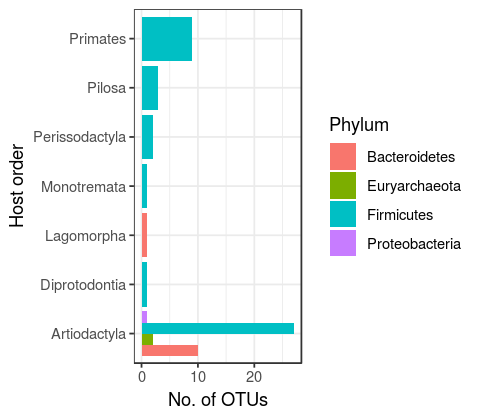

In [114]:
# summary plot by (class)
lipa_sub_res_s_j_s = lipa_sub_res_s_j %>%
    distinct(class, order, Phylum, OTU) %>%
    group_by(class, order, Phylum) %>%
    summarize(n=n()) %>%
    ungroup()

p = ggplot(lipa_sub_res_s_j_s, aes(order, n, fill=Phylum)) +
    geom_bar(stat='identity', position='dodge') +
    labs(x='Host order', y='No. of OTUs') +
    coord_flip() +
    theme_bw() 

options(repr.plot.width=4, repr.plot.height=3.5)
plot_write(p, file='OTU-binom_lipamoran_sigOTUs_byOrder_justMam.pdf')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/OTU-binom_lipamoran_sigOTUs_byClass-diet_justMam.pdf 


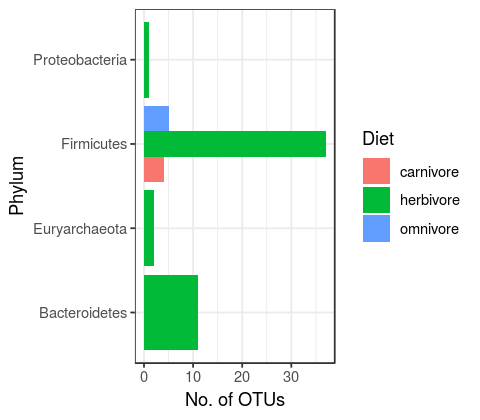

In [115]:
# summary plot by (class & diet)
lipa_sub_res_s_j_s = lipa_sub_res_s_j %>%
    distinct(class, Phylum, OTU, diet) %>%
    group_by(class, Phylum, diet) %>%
    summarize(n=n()) %>%
    ungroup()

p = ggplot(lipa_sub_res_s_j_s, aes(Phylum, n, fill=diet)) +
    geom_bar(stat='identity', position='dodge') +
    labs(x='Phylum', y='No. of OTUs') +
    scale_fill_discrete('Diet') +
    #facet_grid(class ~ ., scales='free_x') +
    coord_flip() +
    theme_bw() 

options(repr.plot.width=4, repr.plot.height=3.5)
plot_write(p, file='OTU-binom_lipamoran_sigOTUs_byClass-diet_justMam.pdf')

In [116]:
# number of OTUs per sample
lipa_sub_res_s_j %>%
    distinct(scientific_name, OTU) %>%
    group_by(scientific_name) %>%
    summarize(n_OTUs = OTU %>% length) %>%
    ungroup() %>%
    .$n_OTUs %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   3.000   5.875   7.000  21.000 

### Formatting for iTOL

#### Number of OTUs per species

* OTUs grouped at phylum level

In [117]:
lipa_sub_res_s_j_s = lipa_sub_res_s_j %>%
    mutate(scientific_name = gsub(' ', '_', scientific_name)) %>%
    group_by(scientific_name, Phylum) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    spread(Phylum, n, fill=0) %>%
    as.data.frame

rownames(lipa_sub_res_s_j_s) = lipa_sub_res_s_j_s$scientific_name
lipa_sub_res_s_j_s$scientific_name = NULL
lipa_sub_res_s_j_s %>% dfhead

[1] 16  4


,Bacteroidetes,Euryarchaeota,Firmicutes,Proteobacteria
Bos_frontalis,2,2,16,1
Bos_taurus,2,1,10,0
Bradypus_variegatus,0,0,3,0


In [118]:
# summary barplot w/ number of OTUs per host
itol_multibar(lipa_sub_res_s_j_s, 'lipaMoran_num_OTUs_binom', 
              'OTU-binom_lipaMoran-IndD-sens_phylum-multibar_justMam.txt', work_dir)

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//OTU-binom_lipaMoran-IndD-sens_phylum-multibar_justMam.txt 


#### Heatmap of OTUs

In [119]:
lipa_sub_res_s_j %>% dfhead

[1] 94 18


OTU,scientific_name,median_coef,mean_coef,sd_coef,qvalue,Domain,Phylum,Class,Order,Family,Genus,Species,class,order,family,genus,diet
a6b63ad7ca7aeeccf57e834989258c51,Bos_frontalis,0.8901261,0.8773123,0.09769379,0.018867925,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae,Mammalia,Artiodactyla,Bovidae,Bos,herbivore
a6b63ad7ca7aeeccf57e834989258c51,Bos_taurus,0.8859915,0.8860314,0.10862238,0.006622517,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae,Mammalia,Artiodactyla,Bovidae,Bos,herbivore
a6b63ad7ca7aeeccf57e834989258c51,Syncerus_caffer,0.6637282,0.6795396,0.10382534,0.010000000,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae,Mammalia,Artiodactyla,Bovidae,Syncerus,herbivore



Setting initial dates...
Fitting in progress... get a first set of estimates
         Penalised log-lik = -464.3702 
Optimising rates... dates... -464.3702 
Optimising rates... dates... -464.3622 

Done.


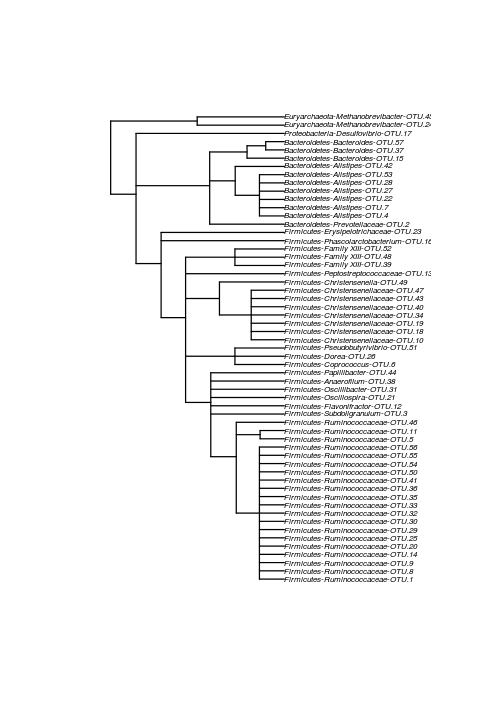

In [120]:
# creating cladogram of taxa
tmp = lipa_sub_res_s_j %>%
    distinct(Domain, Phylum, Class, Order, Family, Genus, Species, OTU) %>%
    mutate(OTU_ID = gsub('^', 'OTU.', OTU %>% as.factor %>% as.numeric)) %>%
    unite('Genus_OTU', c('Phylum', 'Genus', 'OTU_ID'), sep='-', remove=FALSE) %>%
    mutate(Domain = Domain %>% as.factor,
           Phylum = Phylum %>% as.factor,
           Class = Class %>% as.factor,
           Order = Order %>% as.factor,
           Family = Family %>% as.factor,
           Genus = Genus %>% as.factor,
           Species = Species %>% as.factor,
           Genus_OTU = Genus_OTU %>% as.factor) 

clado = as.phylo(~Domain/Phylum/Class/Order/Family/Genus/Species/Genus_OTU, data=tmp)
clado = compute.brlen(clado, 1)
clado = chronos(clado)
options(repr.plot.height=6)
plot(clado, cex=0.4)

In [121]:
# 16S tree
tree16S = readRDS(physeq_file) %>% phy_tree
tree16S$tip.label = gsub('^([0-9])', 'X\\1', tree16S$tip.label)

# filtering
to_rm = setdiff(tree16S$tip.label, lipa_sub_res_s_j$OTU)
tree16S = drop.tip(tree16S, to_rm)

# renaming
x = tmp %>% dplyr::select(OTU, Genus_OTU) %>% as.data.frame
rownames(x) = x$OTU
tree16S$tip.label = x[tree16S$tip.label, 'Genus_OTU']

# status
tree16S


Phylogenetic tree with 57 tips and 56 internal nodes.

Tip labels:
	Euryarchaeota-Methanobrevibacter-OTU.45, Euryarchaeota-Methanobrevibacter-OTU.24, Proteobacteria-Desulfovibrio-OTU.17, Firmicutes-Phascolarctobacterium-OTU.16, Firmicutes-Christensenellaceae-OTU.43, Firmicutes-Christensenellaceae-OTU.19, ...
Node labels:
	0.435, 0.783, 0.812, 0.000, 0.726, 0.149, ...

Rooted; includes branch lengths.

In [122]:
# one row per OTU-host?
lipa_sub_res_s_j %>%
    group_by(OTU, scientific_name) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    .$n %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

In [123]:
# formatting data frame
lipa_sub_res_s_j_f = lipa_sub_res_s_j %>% 
    mutate(scientific_name = gsub(' ', '_',  scientific_name)) %>%
    inner_join(tmp %>% dplyr::select(OTU, Genus_OTU), c('OTU')) %>%
    dplyr::select(Genus_OTU, scientific_name, mean_coef) %>%
    spread(Genus_OTU, mean_coef) %>%
    as.data.frame

#rownames(lipa_sub_res_s_j_f) = gsub('X([0-9])', '\\1', lipa_sub_res_s_j_f$scientific_name)
rownames(lipa_sub_res_s_j_f) = lipa_sub_res_s_j_f$scientific_name
lipa_sub_res_s_j_f$scientific_name = NULL
lipa_sub_res_s_j_f %>% dfhead

[1] 16 57


,Bacteroidetes-Alistipes-OTU.22,Bacteroidetes-Alistipes-OTU.27,Bacteroidetes-Alistipes-OTU.28,Bacteroidetes-Alistipes-OTU.4,Bacteroidetes-Alistipes-OTU.42,Bacteroidetes-Alistipes-OTU.53,Bacteroidetes-Alistipes-OTU.7,Bacteroidetes-Bacteroides-OTU.15,Bacteroidetes-Bacteroides-OTU.37,Bacteroidetes-Bacteroides-OTU.57,⋯,Firmicutes-Ruminococcaceae-OTU.46,Firmicutes-Ruminococcaceae-OTU.5,Firmicutes-Ruminococcaceae-OTU.50,Firmicutes-Ruminococcaceae-OTU.54,Firmicutes-Ruminococcaceae-OTU.55,Firmicutes-Ruminococcaceae-OTU.56,Firmicutes-Ruminococcaceae-OTU.8,Firmicutes-Ruminococcaceae-OTU.9,Firmicutes-Subdoligranulum-OTU.3,Proteobacteria-Desulfovibrio-OTU.17
Bos_frontalis,0.8663042,NA,NA,0.8962607,NA,NA,NA,NA,NA,NA,⋯,NA,0.8505474,NA,0.7432987,NA,NA,0.8766905,1.049576,NA,0.7708265
Bos_taurus,0.8250145,NA,NA,0.8758964,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,0.950875,NA,NA
Bradypus_variegatus,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,0.7670632,NA,NA,NA,NA,NA,NA,NA,0.8022594,NA


In [124]:
# heatmap w/ cladogram
itol_heatmap(lipa_sub_res_s_j_f, 'lipaMoran_OTU_binom', 
              'OTU-binom_lipaMoran-IndD-sens_OTU-htmap_justMam.txt', work_dir,
              tree=clado)

Warning message in if (color_scheme == "color") {:
“the condition has length > 1 and only the first element will be used”

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//OTU-binom_lipaMoran-IndD-sens_OTU-htmap_justMam.txt 


In [125]:
# heatmap w/ 16S tree
itol_heatmap(lipa_sub_res_s_j_f, 'lipaMoran_OTU_binom_16S', 
              'OTU-binom_lipaMoran-IndD-sens_OTU-htmap-16S_justMam.txt', work_dir,
              tree=tree16S)

Warning message in if (color_scheme == "color") {:
“the condition has length > 1 and only the first element will be used”

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//OTU-binom_lipaMoran-IndD-sens_OTU-htmap-16S_justMam.txt 


#### Cladogram with full taxonomy for labels


Setting initial dates...
Fitting in progress... get a first set of estimates
         Penalised log-lik = -464.3702 
Optimising rates... dates... -464.3702 
Optimising rates... dates... -464.3622 

Done.


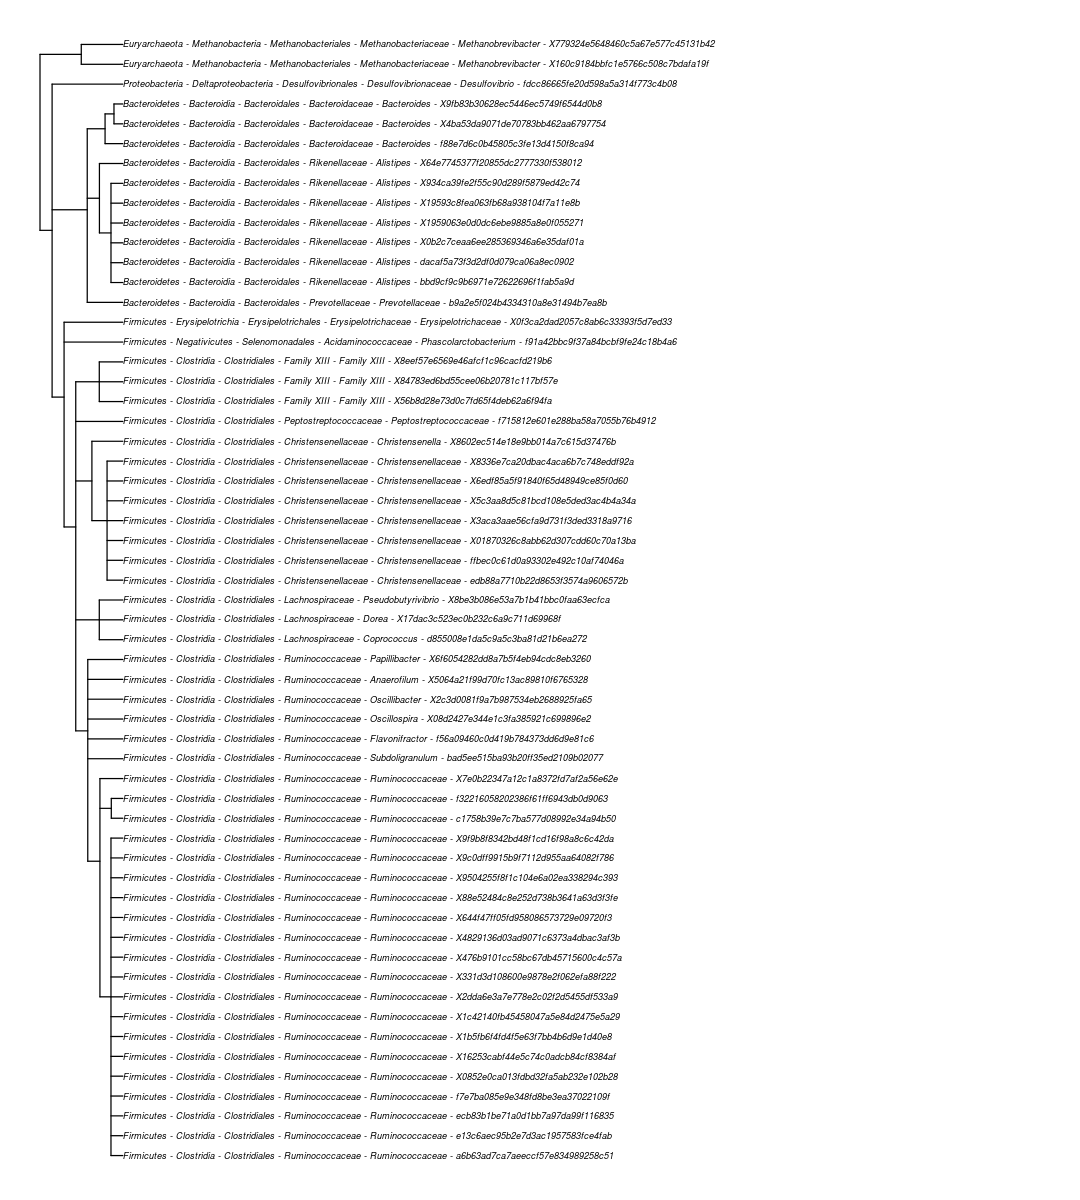

In [126]:
# creating cladogram of taxa
tmp = lipa_sub_res_s_j %>%
    distinct(Domain, Phylum, Class, Order, Family, Genus, Species, OTU) %>%
    #mutate(OTU_ID = gsub('^', 'OTU.', OTU %>% as.factor %>% as.numeric)) %>%
    unite('full_taxonomy', c('Phylum', 'Class', 'Order', 'Family', 'Genus', 'OTU'), 
          sep=' - ', remove=FALSE) %>%
    mutate(Domain = Domain %>% as.factor,
           Phylum = Phylum %>% as.factor,
           Class = Class %>% as.factor,
           Order = Order %>% as.factor,
           Family = Family %>% as.factor,
           Genus = Genus %>% as.factor,
           Species = Species %>% as.factor,
           full_taxonomy = full_taxonomy %>% as.factor) 

clado = as.phylo(~Domain/Phylum/Class/Order/Family/Genus/Species/full_taxonomy, data=tmp)
clado = compute.brlen(clado, 1)
clado = chronos(clado)
options(repr.plot.height=10, repr.plot.width=9)
plot(clado, cex=0.45, no.margin=TRUE)

In [127]:
clado_file = file.path(work_dir, 'OTU-binom_lipaMoran-IndD-sens_clado_justMam.nwk')
write.tree(clado, file=clado_file)
cat('File written:', clado_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//OTU-binom_lipaMoran-IndD-sens_clado_justMam.nwk 


# sessionInfo

In [128]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_phylo/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_phylo/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] bindrcpp_0.2.2          future.apply_1.0.0      future.batchtools_0.7.1
 [4] future_1.9.0            doParallel_1.0.11       iterators_1.0.10       
 [7] foreach_1.4.4           phylosignal_1.2         phyloseq_1.22.3        
[10] ape_5.1                 ggplot2_3.0.0           tidyr_0.8.1            
[13] dplyr_0.7.6            

loaded via a namespace (and not attached):
 [1] nlme_3.1-131        fs_1.2.4            gmodels_2.18.1     
 [4] progress_1.2.0      httr_1.3.1          repr_0.15.0        
 